In [64]:
import numpy as np
import pandas as pd
import functions.multi_occupation_network as multi_occupation_network
import functions.nominal_rigidity_network as nominal_rigidity_network
import matplotlib.pyplot as plt
from  functions.network_figures import bar_plot

# Calibration Excersize 2: One Occupation Per Sector

Suppose there is one type of labor specific to each sector, in other words that $\mathcal{O}=J$. We calibrate our model to mathc BEA input-output tables, and treat the residual, the part of production not accounted for by intermediate inputs, as the labor elasticity. 

In [65]:
A_spec = 2
data_dir = '../data/clean/'
dfTau = pd.read_csv(data_dir + 'tau_2021.csv').sort_values(by=['short_names'])
dfA      = pd.read_csv(data_dir + f'A{A_spec}.csv')
sectors = dfA['short_names']
dfDemand  = pd.read_csv(data_dir + 'demand_tab.csv')
dfLshare = pd.read_csv(data_dir + 'labor_tab.csv')
dfLabor_market_yearly= pd.read_csv(data_dir + 'uvh_annual_updated.csv')
dfLabor_market_yearly = dfLabor_market_yearly.sort_values(by=['Year', 'short_names'])
dfLabor_market_yearly = dfLabor_market_yearly.dropna(axis=0)
dfLabor_market_yearly = dfLabor_market_yearly[dfLabor_market_yearly['Year'] == 2021]
dfMatching_params = pd.read_csv(data_dir + 'matching_param_estimates.csv')
shares = pd.read_csv(data_dir + 'energy_capital_shares.csv')
sector_names = list(dfA['short_names']) + ['Agg Y']
occupation_names = list(dfA['short_names'])

In [66]:
shares

,short_names,Capital share,Energy share
0,accom,0.221841,0.023295
1,const,0.097000,0.024000
2,dur,0.271000,0.008000
3,edhealth,0.126015,0.011191
4,fin,0.330830,0.035048
5,gov,0.000000,0.000000
6,info,0.377000,0.004000
7,mining,0.524000,0.029000
8,nondur,0.280069,0.022101
9,other,0.070000,0.010000


In [67]:
# reformatting parameters
Omega = np.array(dfA.iloc[:, 1:], dtype='float64')
# rescale based on energy shares
rescaler = np.matrix(1 - shares['Capital share'] - shares['Energy share'])
J = Omega.shape[0]
Omega = np.multiply(Omega, (np.repeat(rescaler, J)).reshape(J, J))
Psi = np.linalg.inv(np.eye(Omega.shape[0])-Omega)
O = J

epsN = np.diag(np.array(dfLshare[f'labor_elasticity{A_spec}'], dtype='float64'))
epsN = np.multiply(epsN, rescaler)
epsD = np.array(dfDemand['demand_elasticity']).reshape((J,1))
epsK = np.matrix(shares[['Capital share', 'Energy share']])

K = epsK.shape[1]

θ = dfLabor_market_yearly['Tightness'] 
curlyQ = -np.diag(dfMatching_params['unemployment_elasticity'])
curlyF =  np.eye(J) + curlyQ
curlyT = np.diag(dfTau['Tau'])
curlyL = np.eye(J)

We assume Cobb-Douglas production and preferences.

In [68]:
dlog_lam = np.zeros((J, 1))
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
dlog_epsK = np.zeros_like(epsK)

## Response to Energy Shocks

Here, we plot the response to energy shocks under the following wage assumptions: Hulten, 0.5MP, Real rigidity, nominal ridigity, and dampening.

In [69]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O, 1))
dlog_K = np.zeros((K, 1))
dlog_K[1] = -0.01 
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', '0.5MP', 'Rigid Real', 'Rigid Nominal', 'Dampening']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [70]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [71]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [72]:
sectorY_vec.shape

(14, 5)

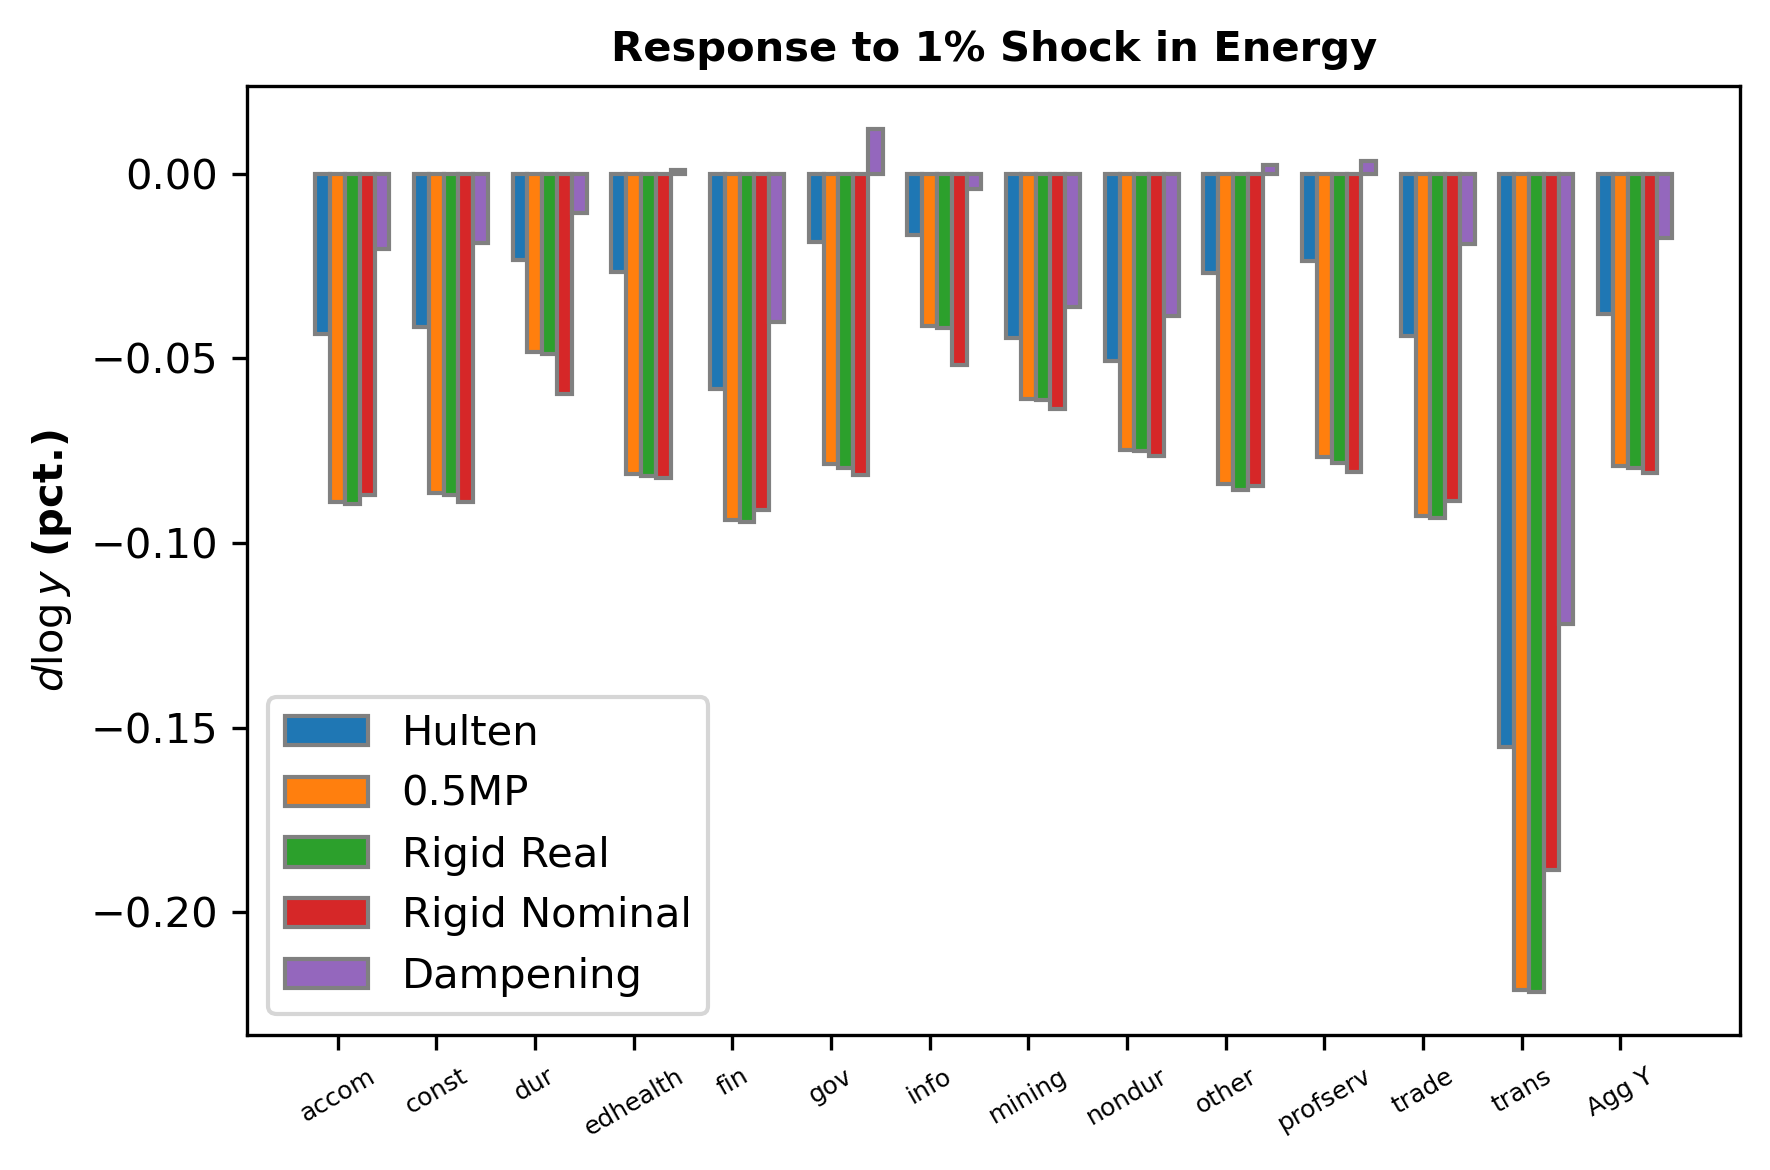

In [73]:
title = f'Response to 1% Shock in Energy'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_KshockY.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

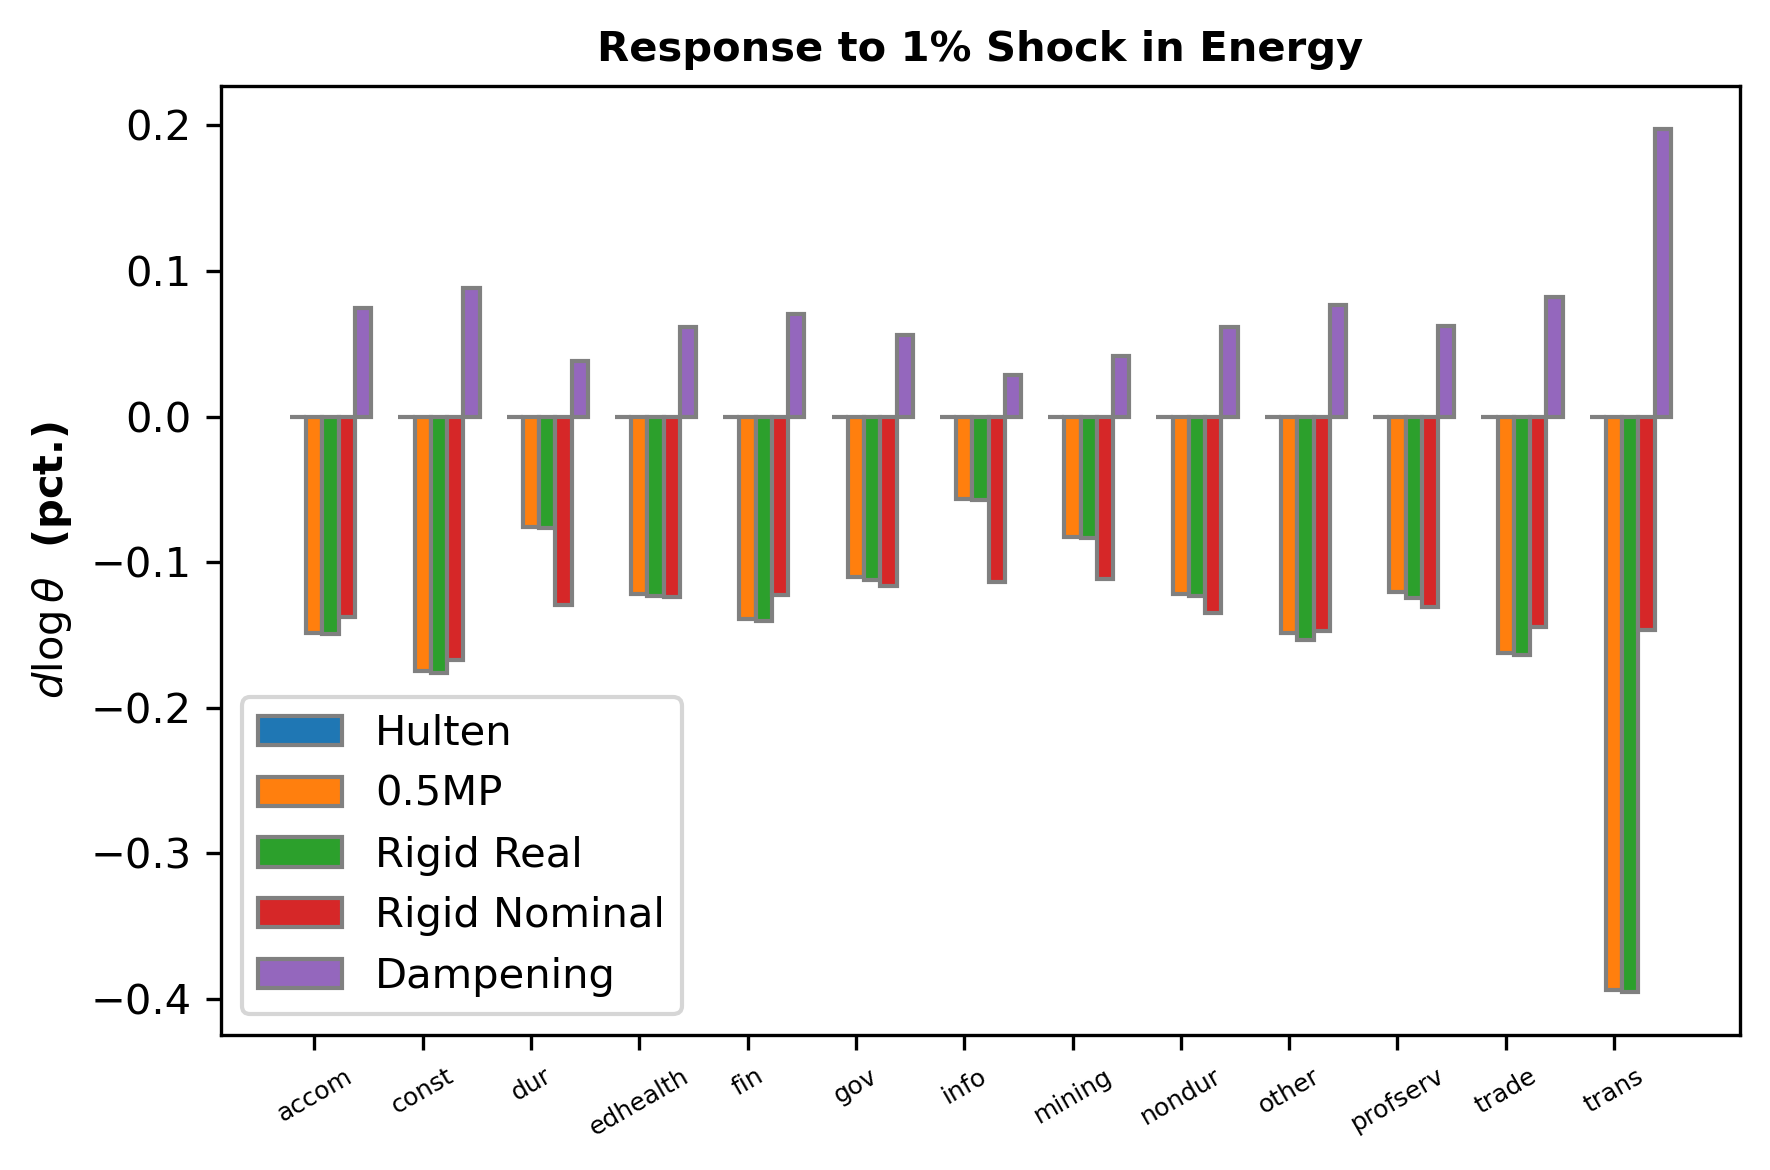

In [74]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_KshockT.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

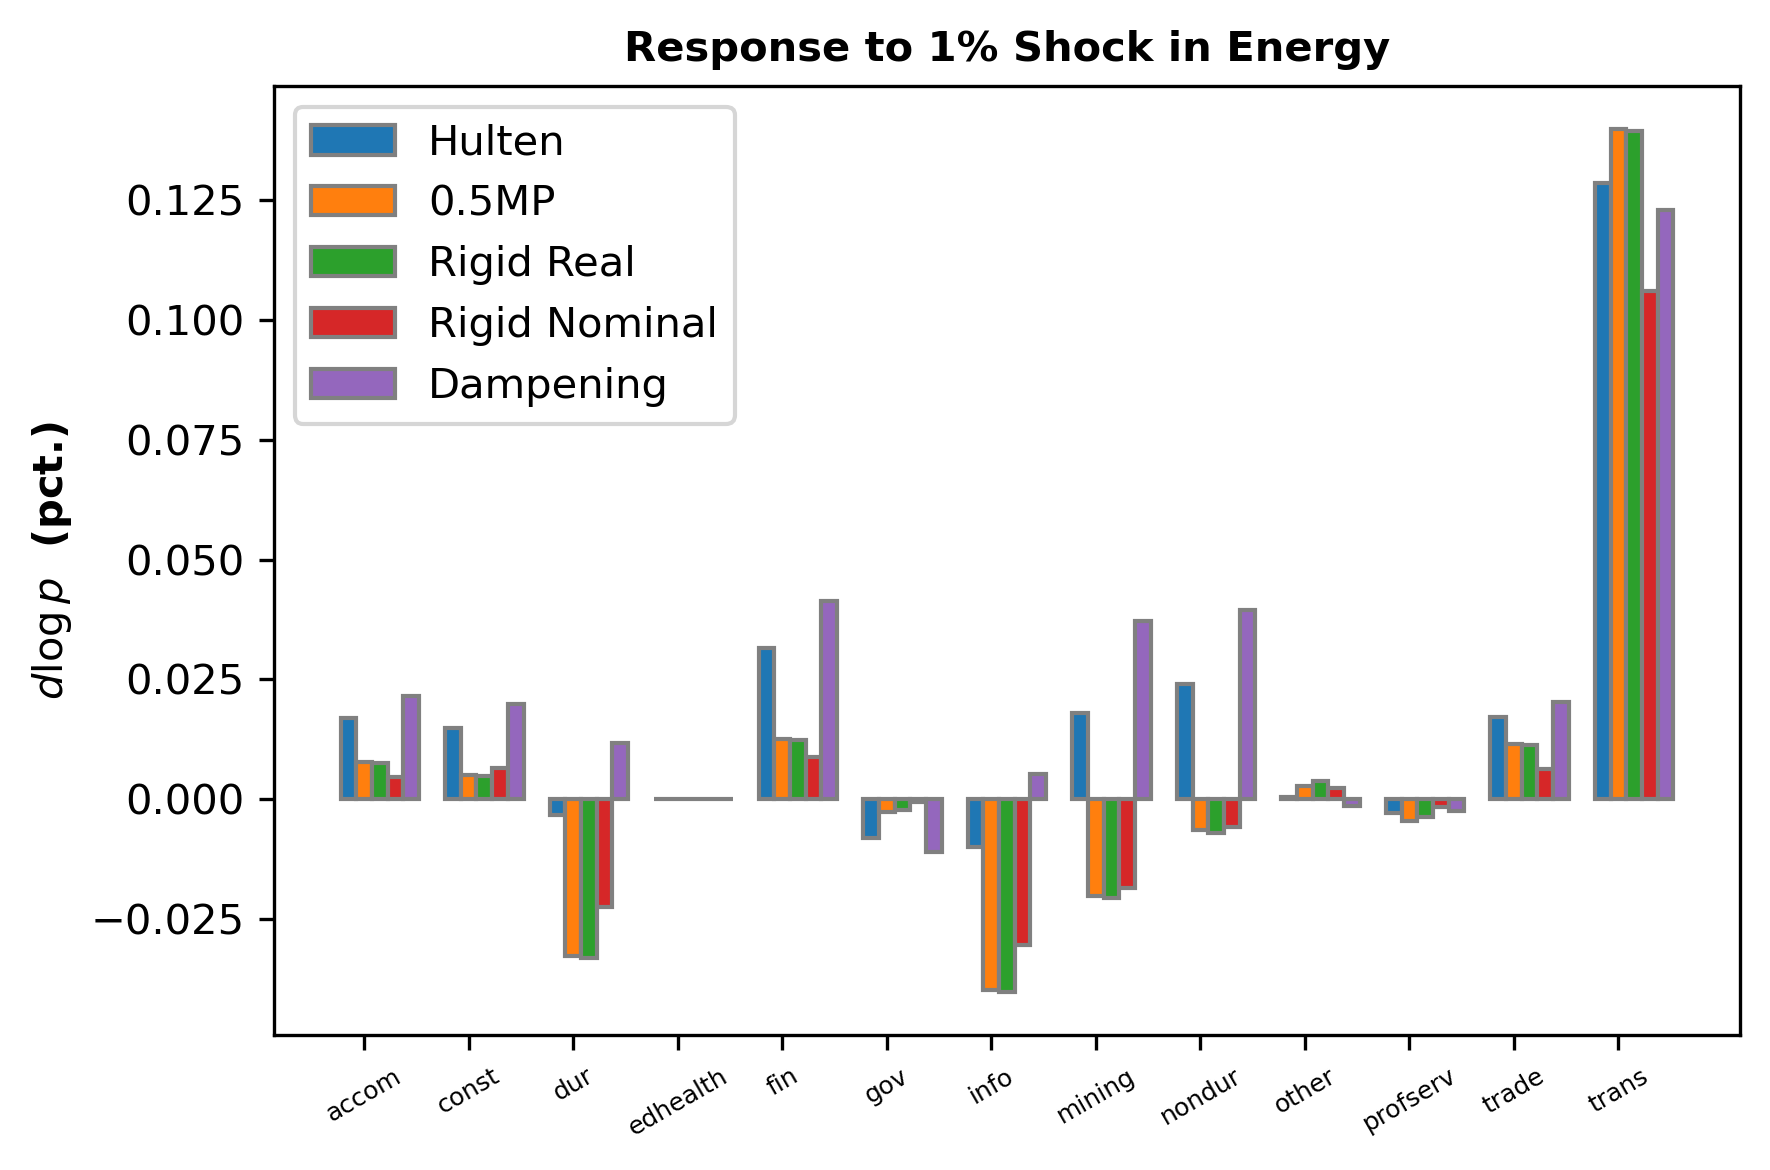

In [75]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_KshockP.png'
labels = PriceAssumption
bar_plot(100*p_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

## Labor Supply Shocks


In [76]:
# Setting which sectors to shock, and getting the full name of the sector. 
sec_to_shock = 'accom'
shock_size = -0.01
shock_ind = sectors[sectors=='accom'].index.values[0]
# For reference, these are other sectors we can shock
print(sectors)
sec_dict = pd.read_excel("../data/raw/long_short_names_crosswalk.xlsx")
sec_full = sec_dict['Industry'][sec_dict['short_names'] == sec_to_shock].iloc[0].title()
print(f'the full name for {sec_to_shock} is {sec_full}')

sectorY_vec = np.zeros((J+1, len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
dlog_A = np.zeros((J,1))
dlog_H = np.zeros((O,1))
dlog_K = np.zeros((K,1))

dlog_H[shock_ind] = shock_size
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', '0.5MP', 'Rigid Real', 'Rigid Nominal', 'Dampening']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

0        accom
1        const
2          dur
3     edhealth
4          fin
5          gov
6         info
7       mining
8       nondur
9        other
10    profserv
11       trade
12       trans
Name: short_names, dtype: object
the full name for accom is Leisure And Hospitality


In [77]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [78]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [79]:
sectorY_vec.shape

(14, 5)

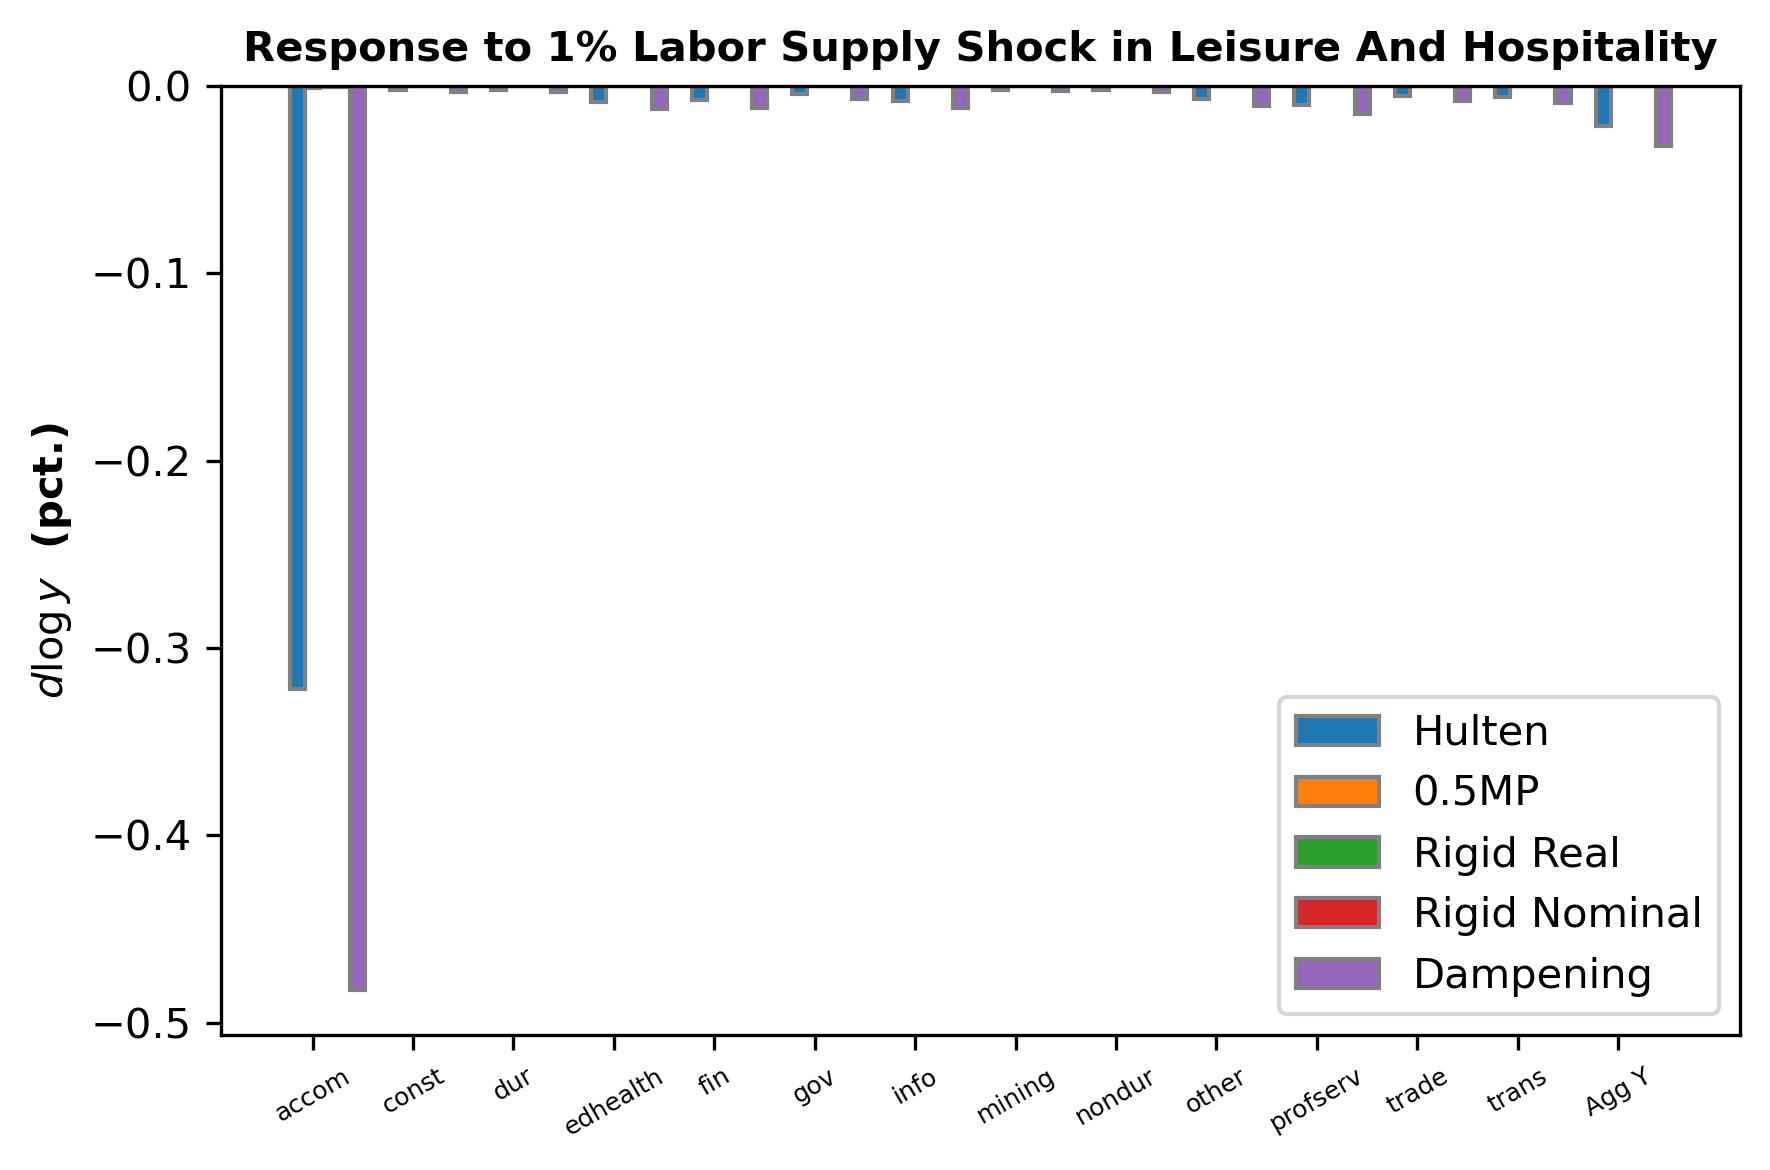

In [80]:
title = f'Response to 1% Labor Supply Shock in {sec_full}'
xlab = ''
ylab = '$d\log y$  (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_H{sec_to_shock}shockY.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

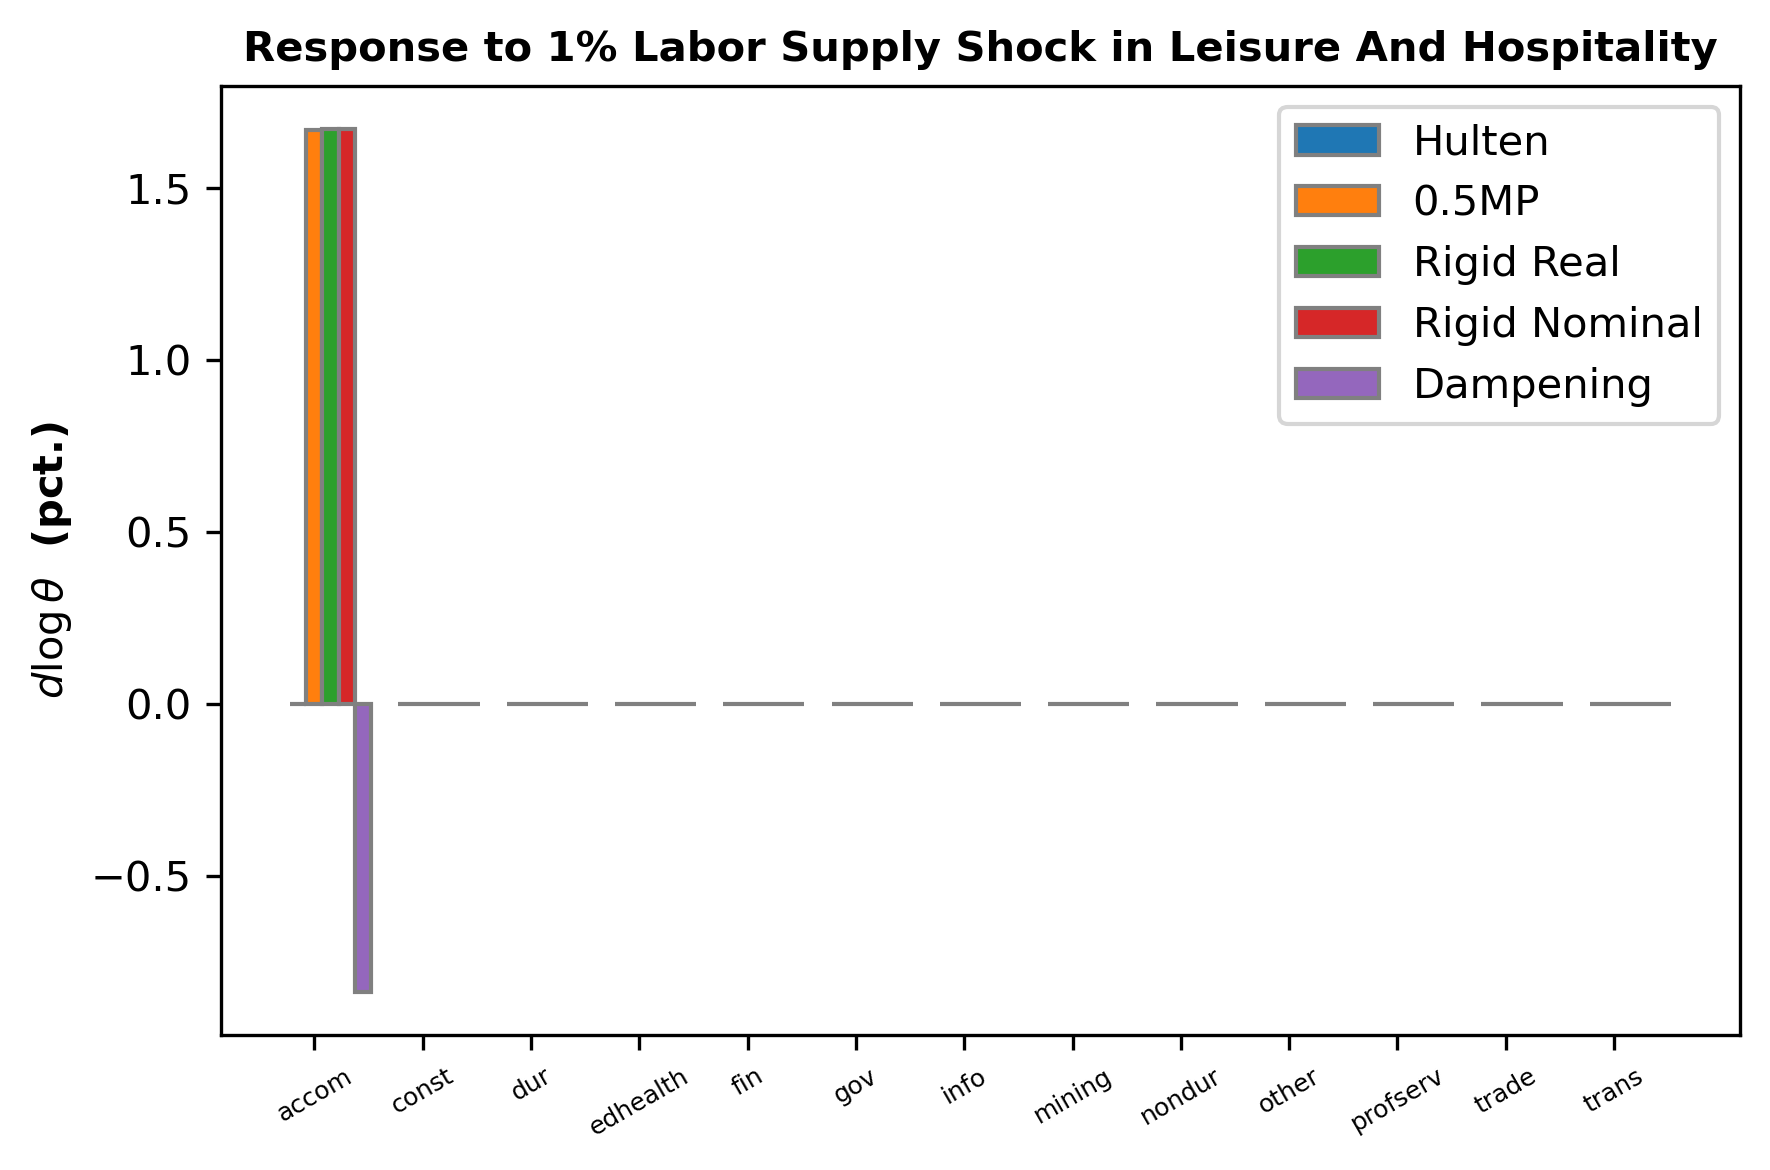

In [81]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_H{sec_to_shock}shockT.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

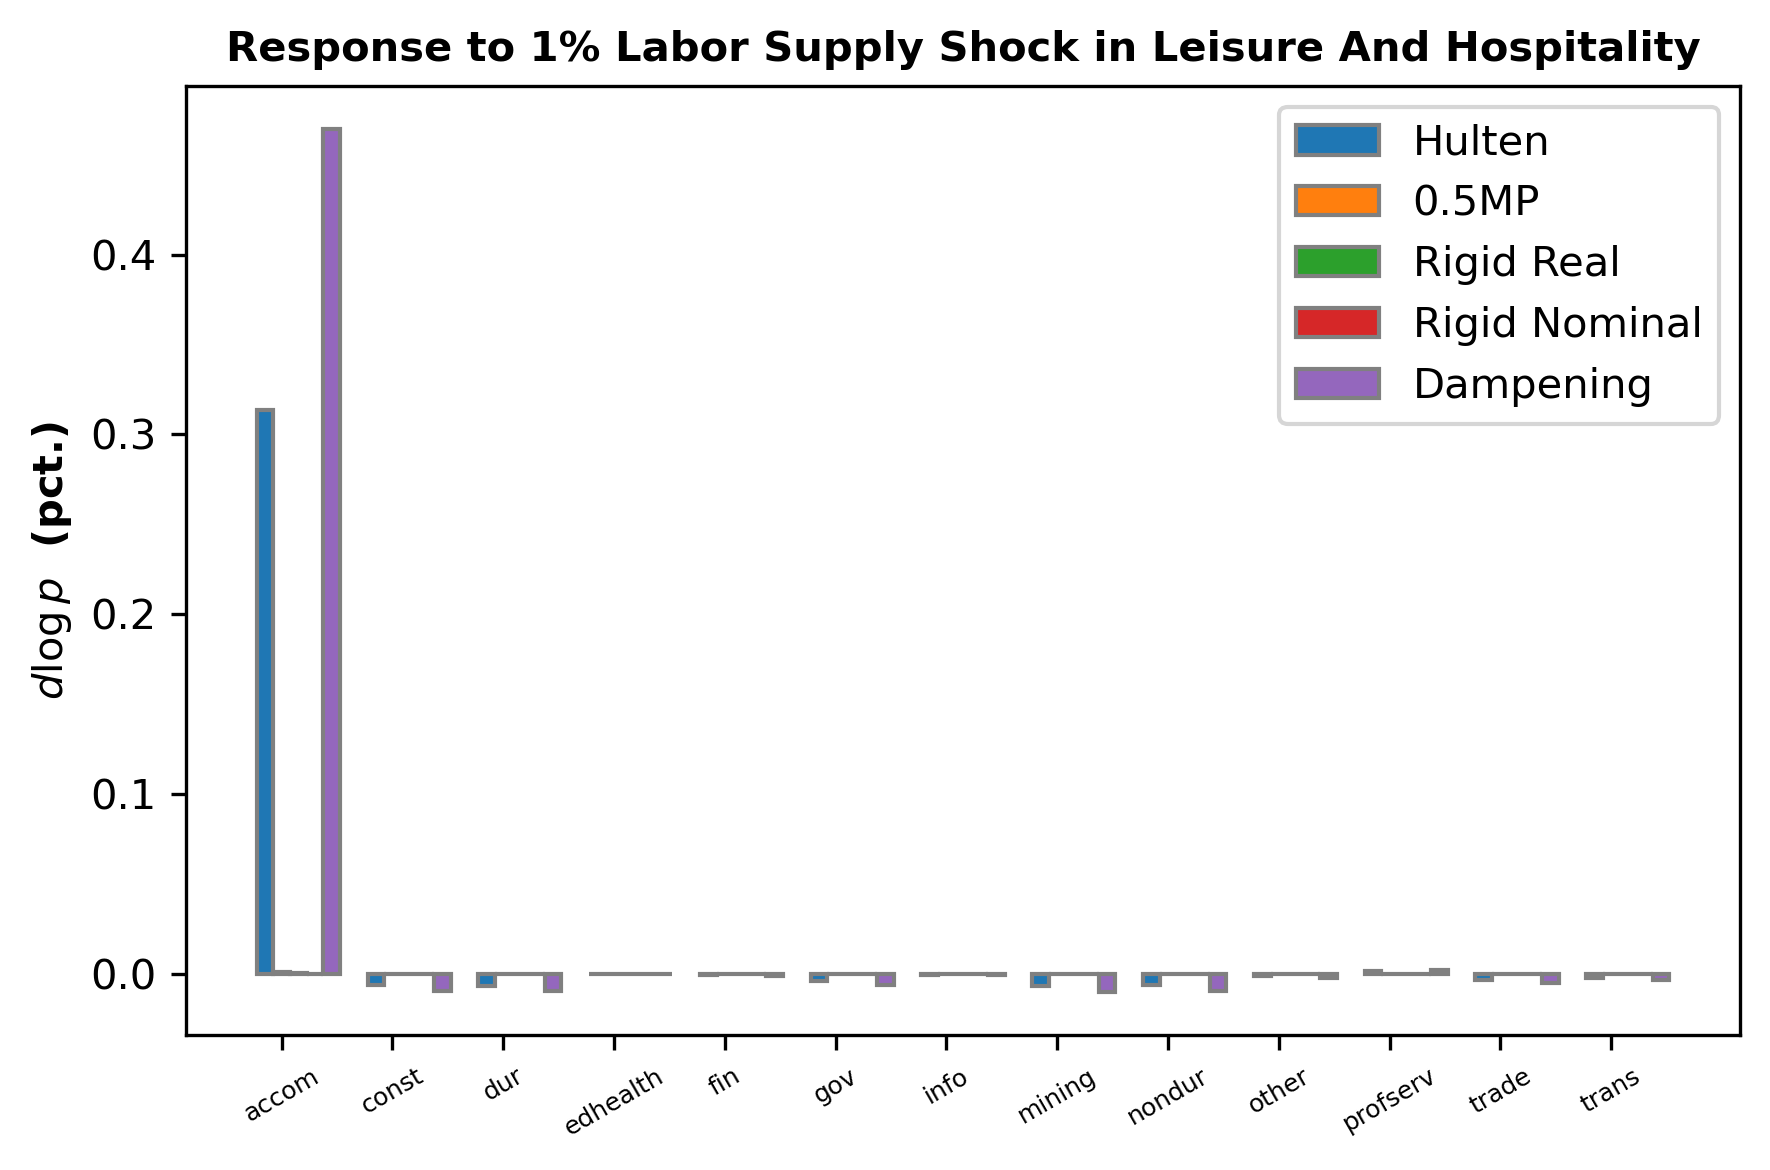

In [82]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_H{sec_to_shock}shockP.png'
labels = PriceAssumption
bar_plot(100*p_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

# Labor Force Participation Shocks

In [83]:
# Setting which sectors to shock, and getting the full name of the sector. 
shock_size = -0.01
# For reference, these are other sectors we can shock
print(sectors)
sec_dict = pd.read_excel("../data/raw/long_short_names_crosswalk.xlsx")
sec_full = sec_dict['Industry'][sec_dict['short_names'] == sec_to_shock].iloc[0].title()
print(f'the full name for {sec_to_shock} is {sec_full}')

sectorY_vec = np.zeros((J+1, len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
dlog_A = np.zeros((J,1))
dlog_H = np.ones((O,1)) * shock_size
dlog_K = np.zeros((K,1))

dlog_H[shock_ind] = shock_size
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', '0.5MP', 'Rigid Real', 'Rigid Nominal', 'Dampening']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

0        accom
1        const
2          dur
3     edhealth
4          fin
5          gov
6         info
7       mining
8       nondur
9        other
10    profserv
11       trade
12       trans
Name: short_names, dtype: object
the full name for accom is Leisure And Hospitality


In [84]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [85]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [86]:
sectorY_vec.shape

(14, 5)

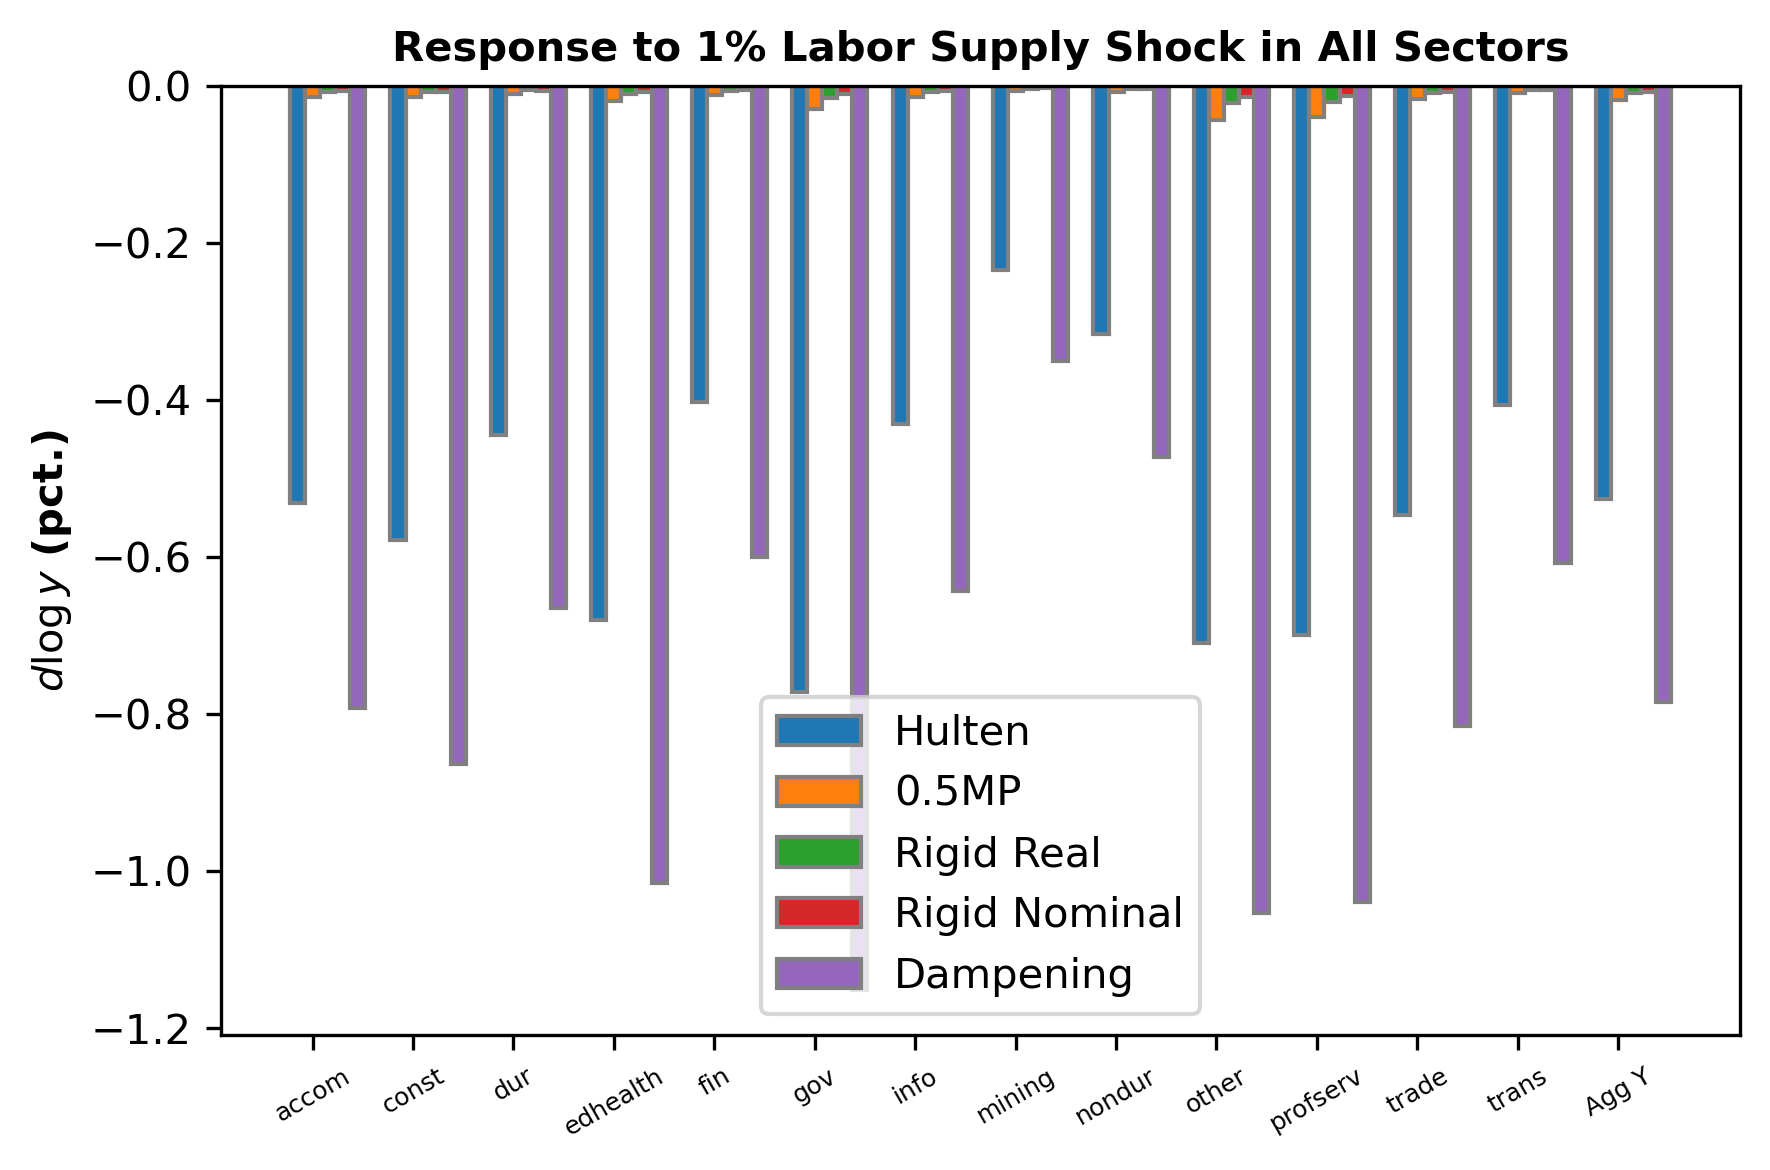

In [87]:
title = f'Response to 1% Labor Supply Shock in All Sectors'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_HallshockY.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

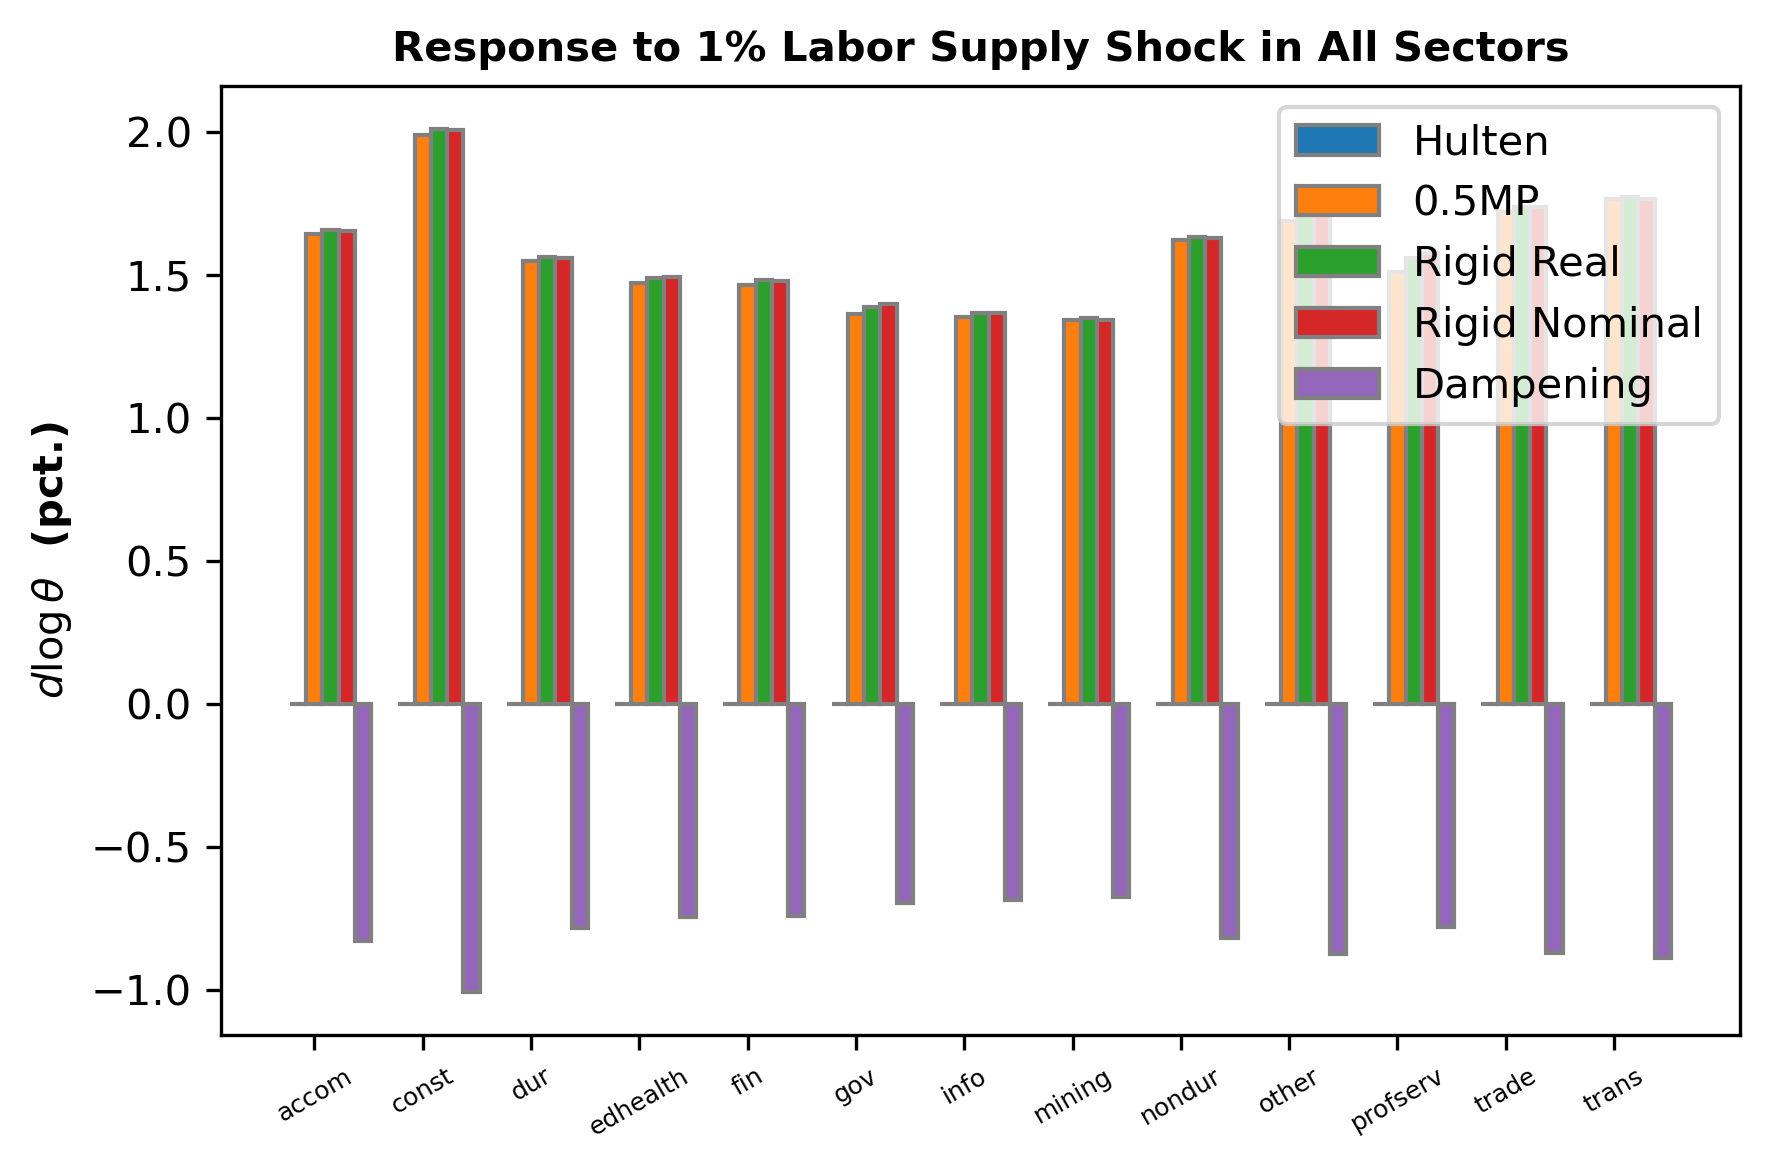

In [88]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_HallshockT.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

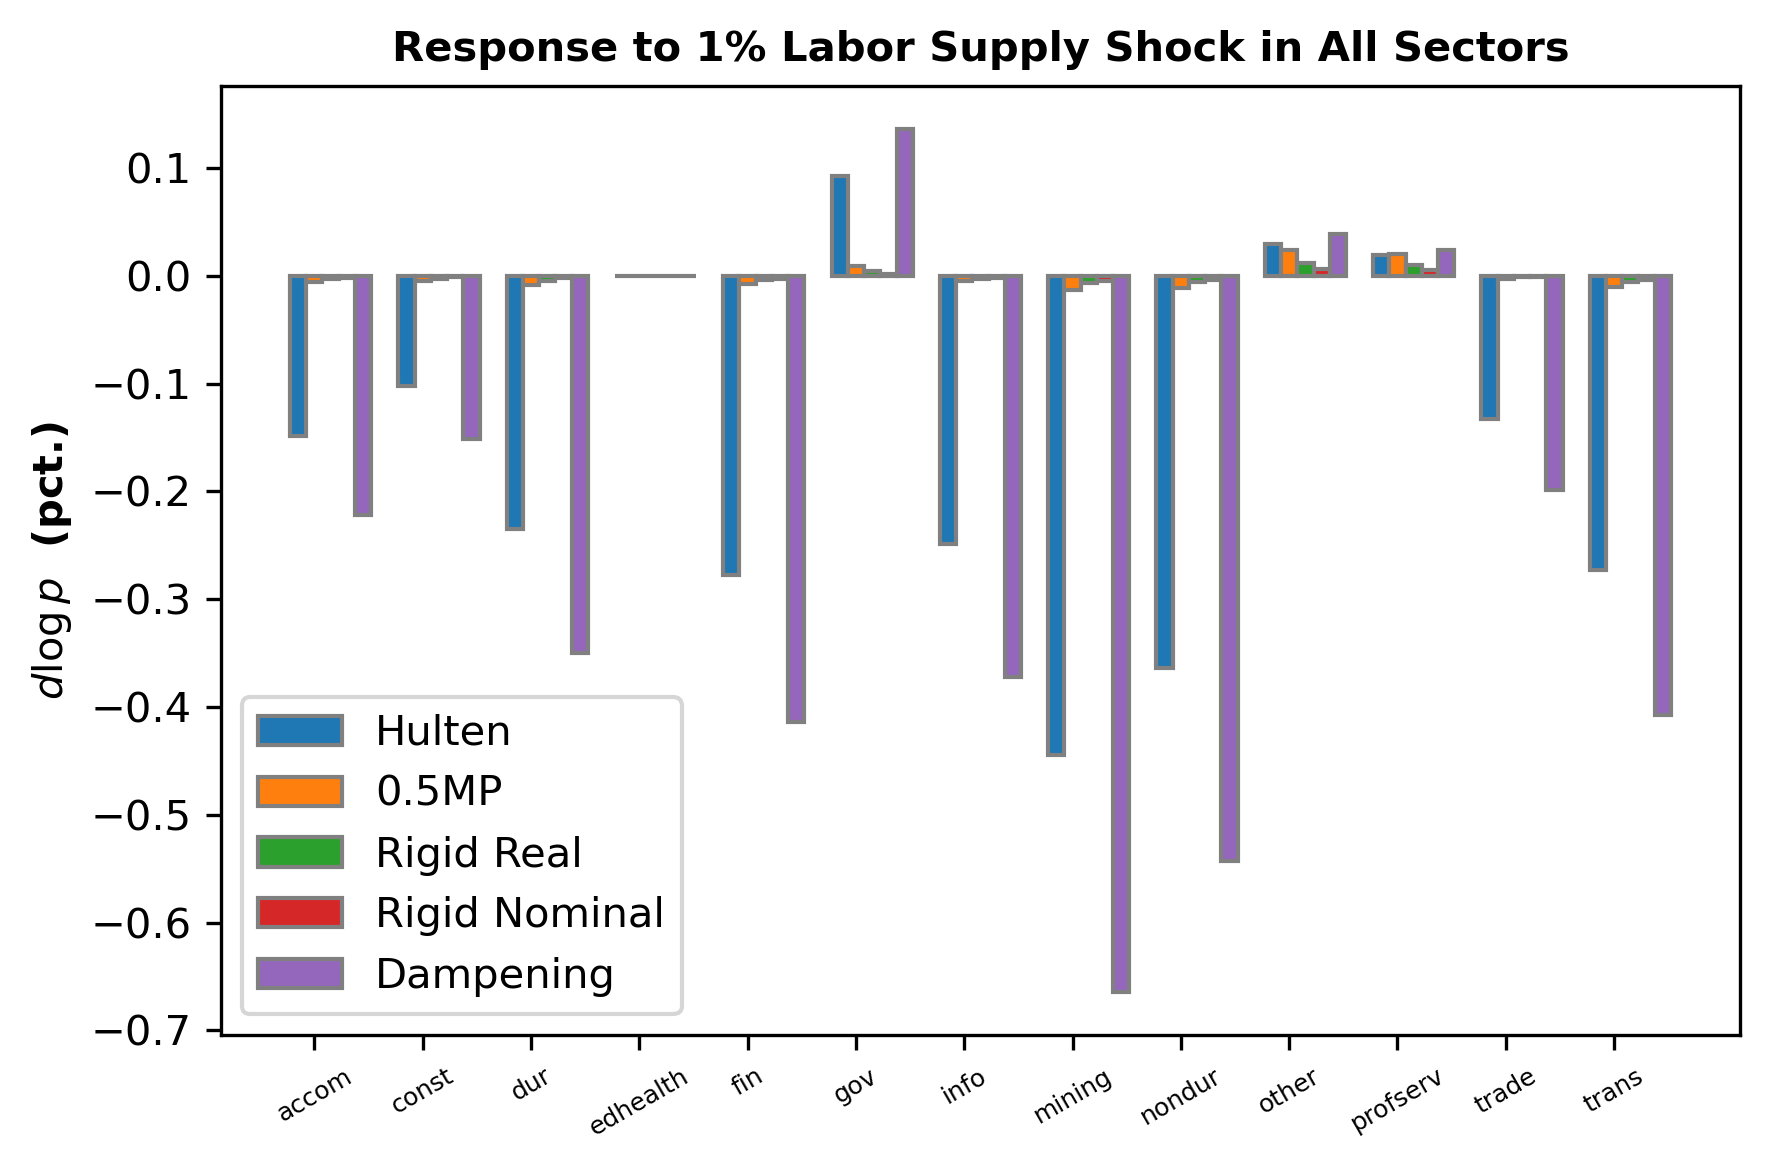

In [89]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_HallshockP.png'
labels = PriceAssumption
bar_plot(100*p_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

In [90]:
dlog_A = np.zeros((J, 1))
dlog_H = np.ones((O, 1)) * -0.01
dlog_H[0] = -0.01
dlog_K = np.zeros((K, 1))
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', '0.5MP', 'Rigid Real', 'Rigid Nominal', 'Dampening']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [91]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [92]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [93]:
sectorY_vec.shape

(14, 5)

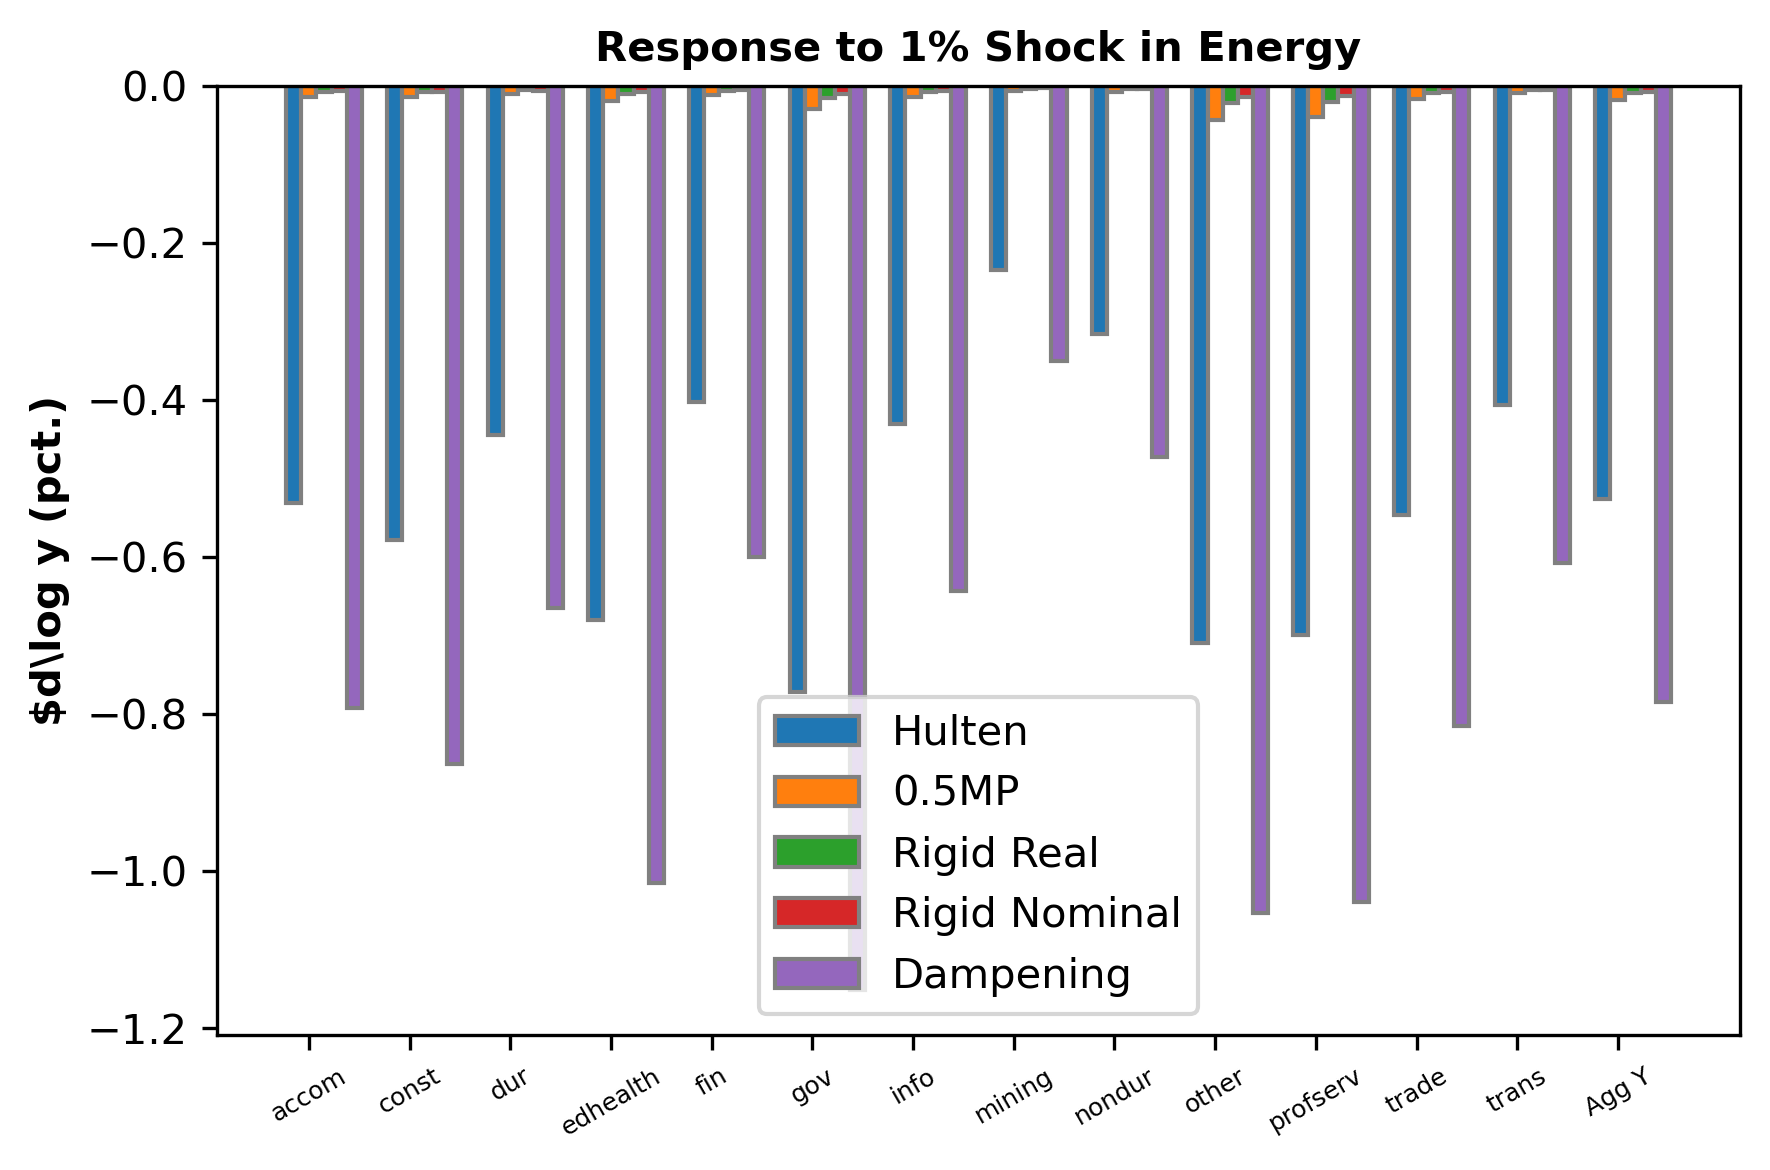

In [94]:
title = f'Response to 1% Shock in Energy'
xlab = ''
ylab = '$d\log y (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_HKshockY.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

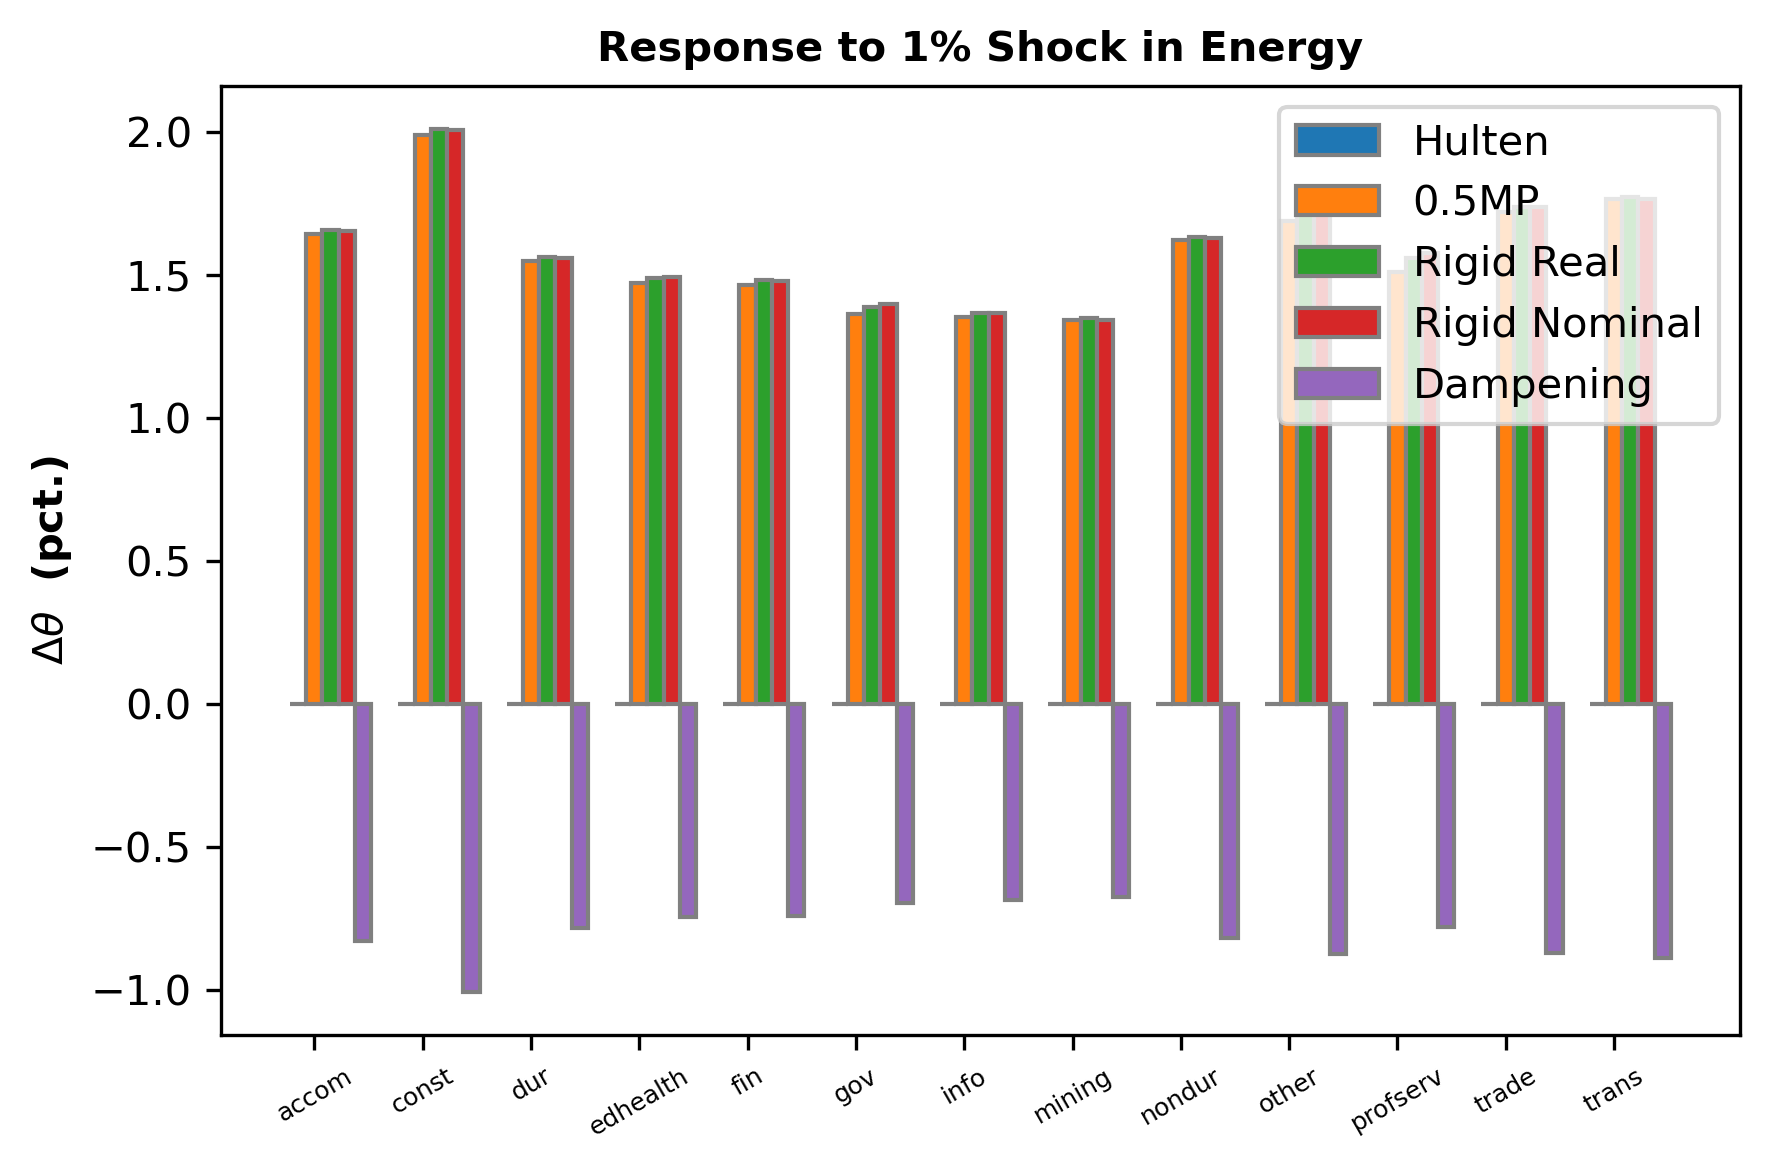

In [95]:
xlab = ''
ylab = '$\Delta \\theta$  (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_HKshockT.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

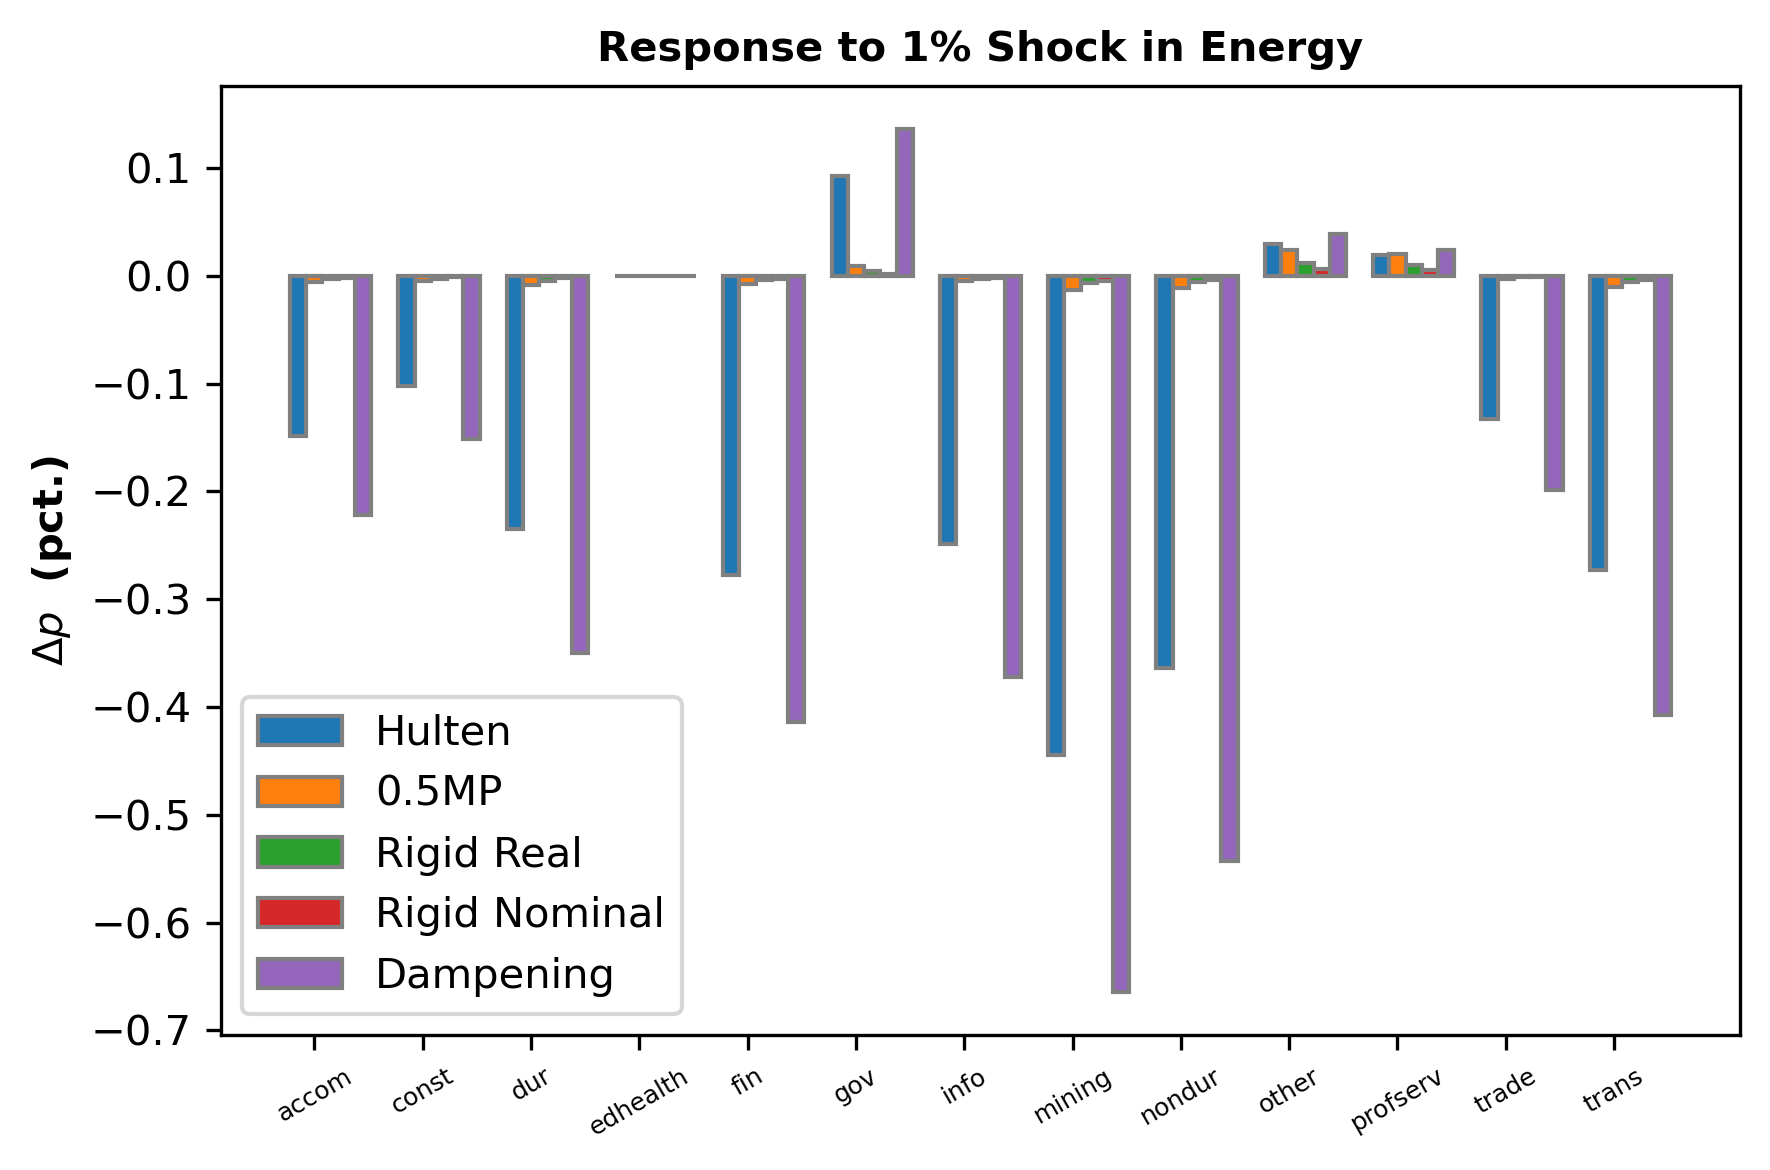

In [96]:
xlab = ''
ylab = '$\Delta p$  (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_HKshockP.png'
labels = PriceAssumption
bar_plot(100*p_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

## Combination shocks


In [97]:
dlog_A = np.zeros((J, 1))
#dlog_A[2] = -0.01
dlog_H = np.ones((O, 1)) * -0.01
#dlog_H[0] = -0.01
#dlog_H[-1] = -0.01
dlog_K = np.zeros((K, 1))
dlog_K[1] = -0.01 
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', '0.5MP', 'Rigid Real', 'Rigid Nominal', 'Dampening']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [98]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [99]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [100]:
sectorY_vec.shape

(14, 5)

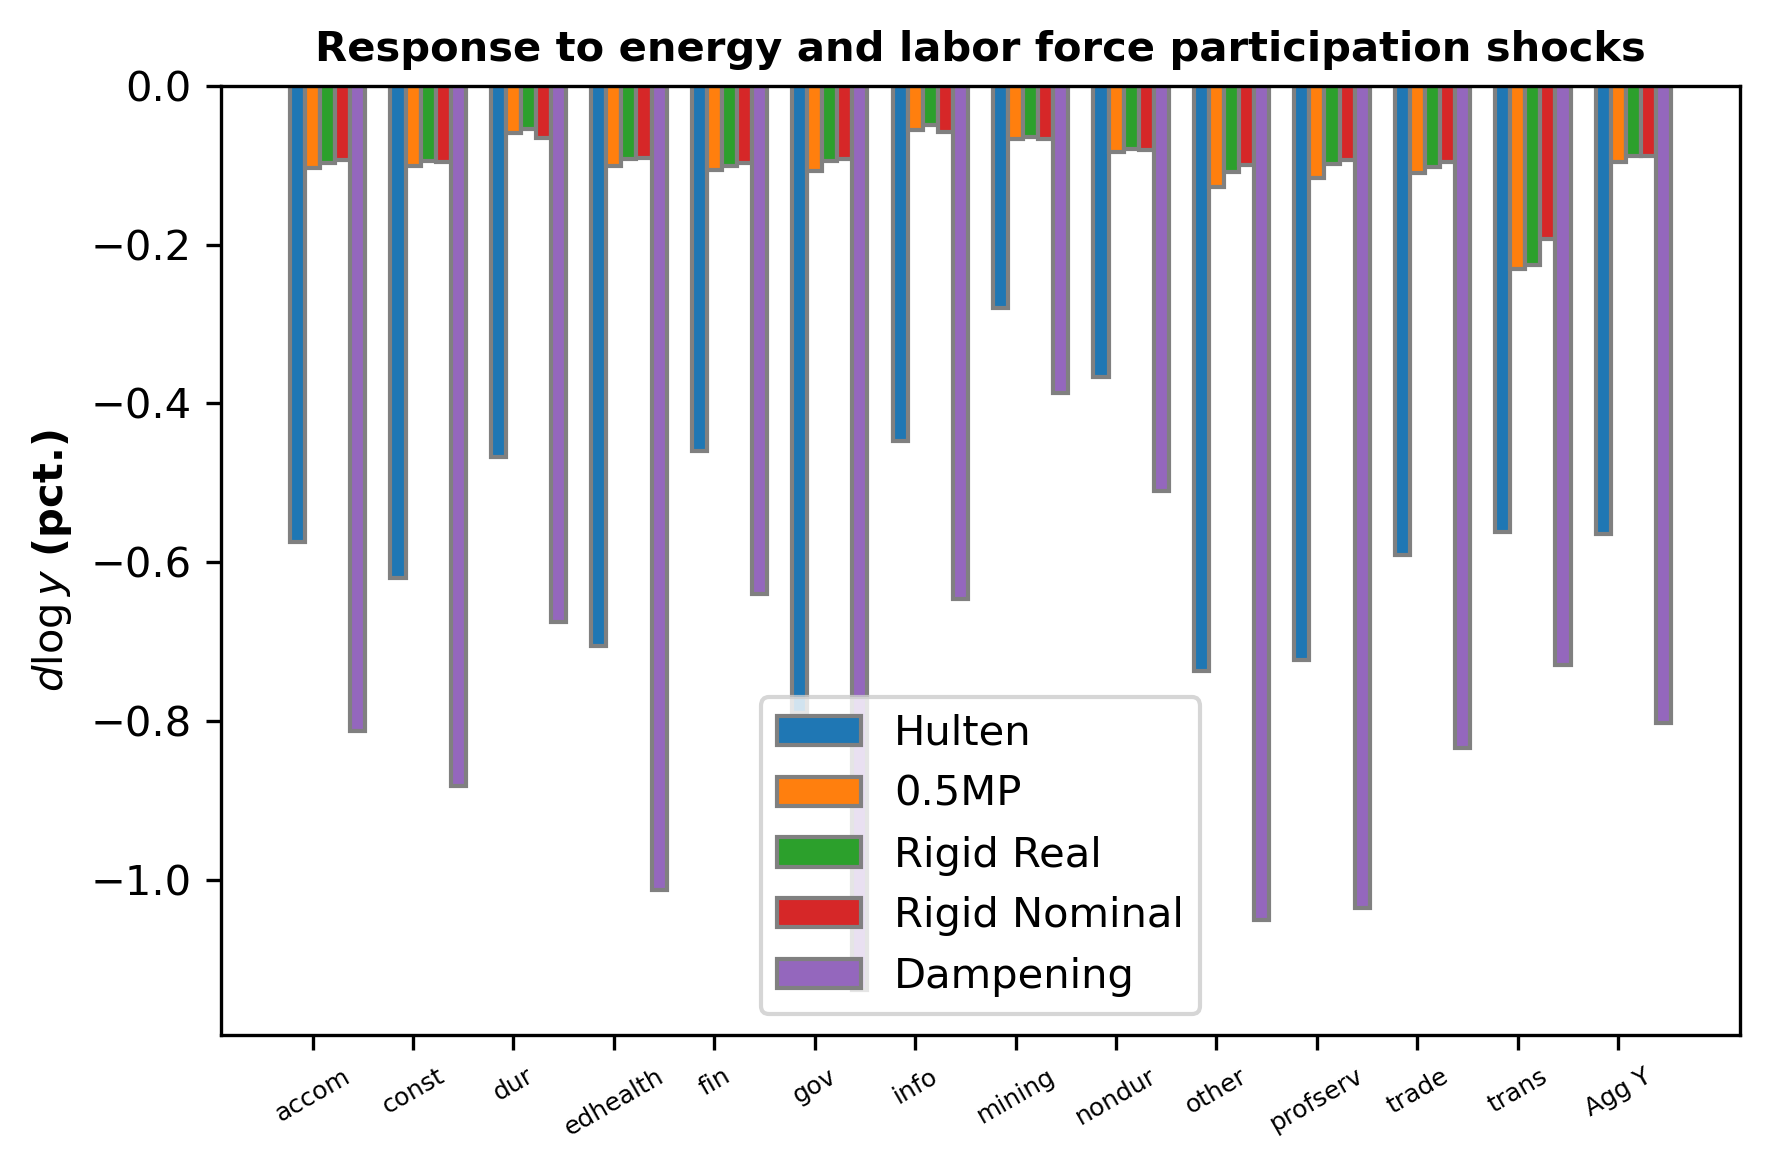

In [101]:
title = f'Response to energy and labor force participation shocks'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_HKshockY.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

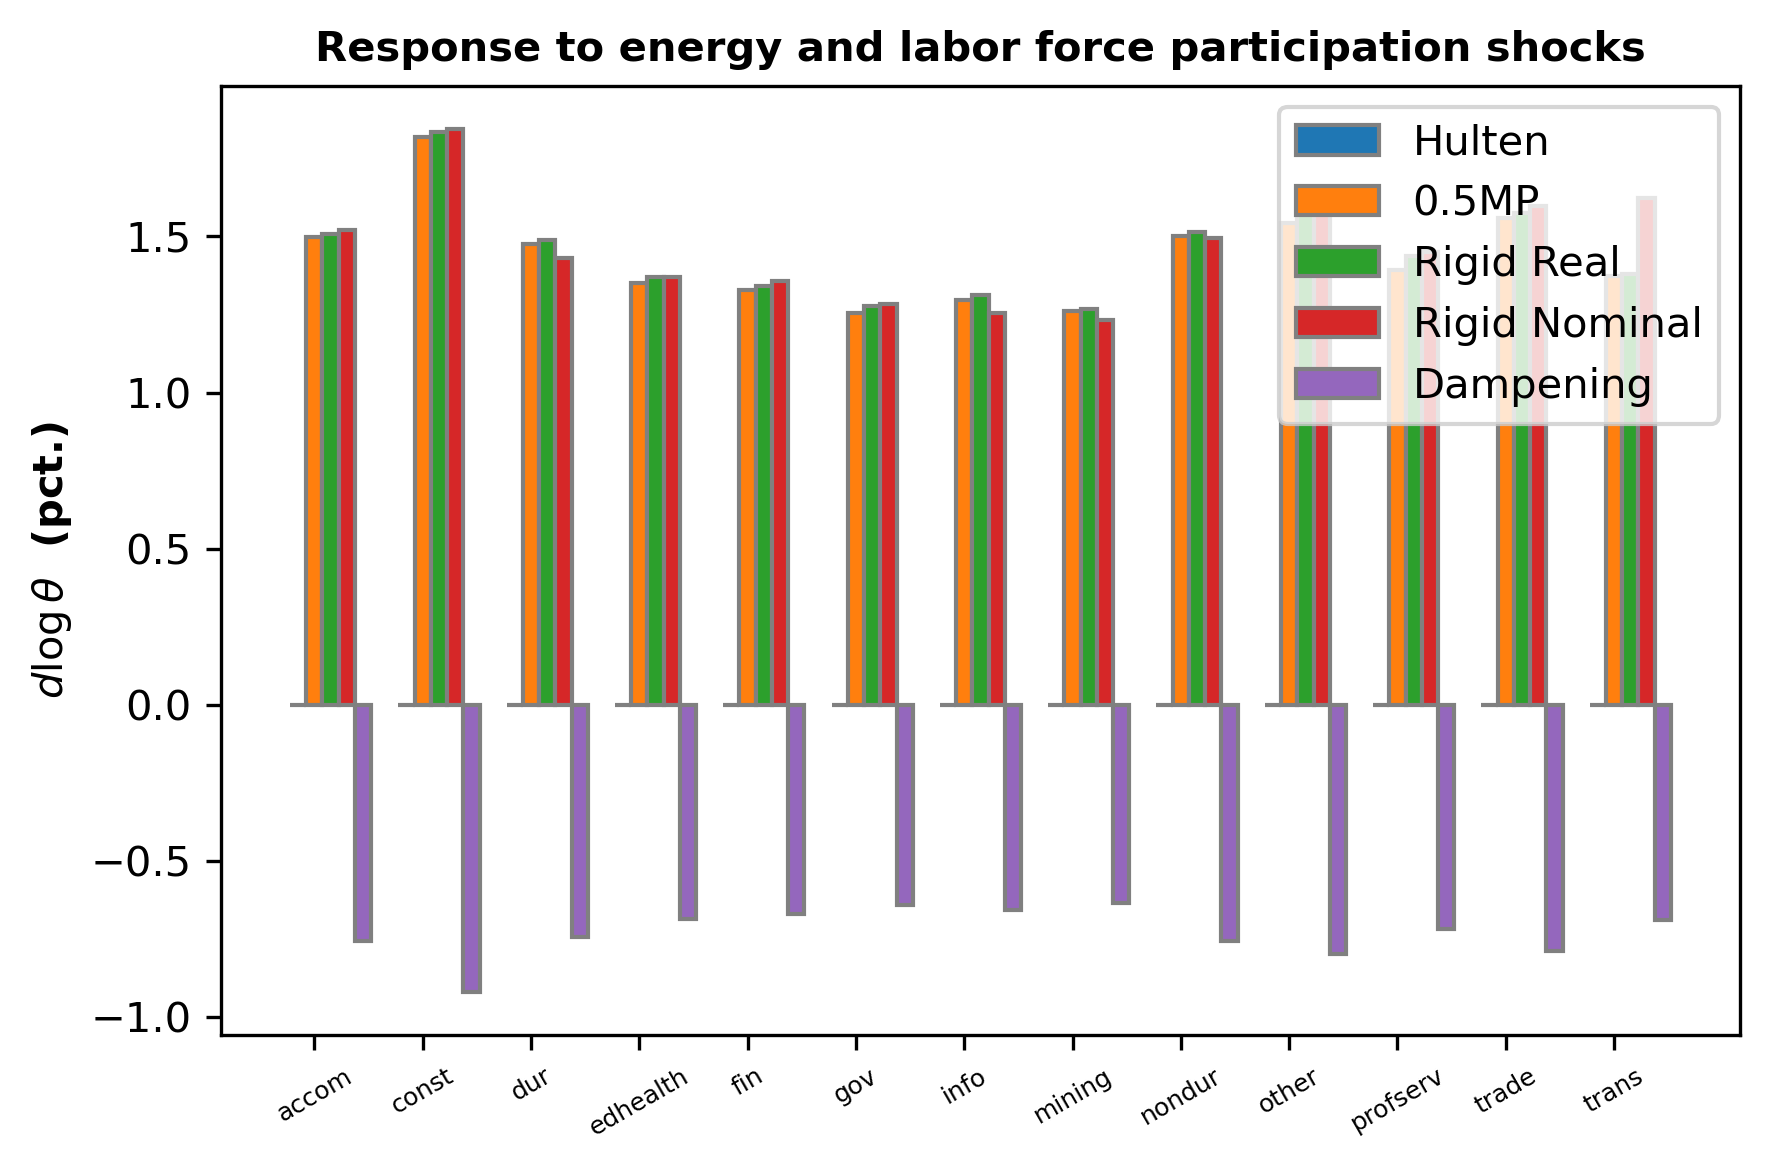

In [102]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_HKshockT.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

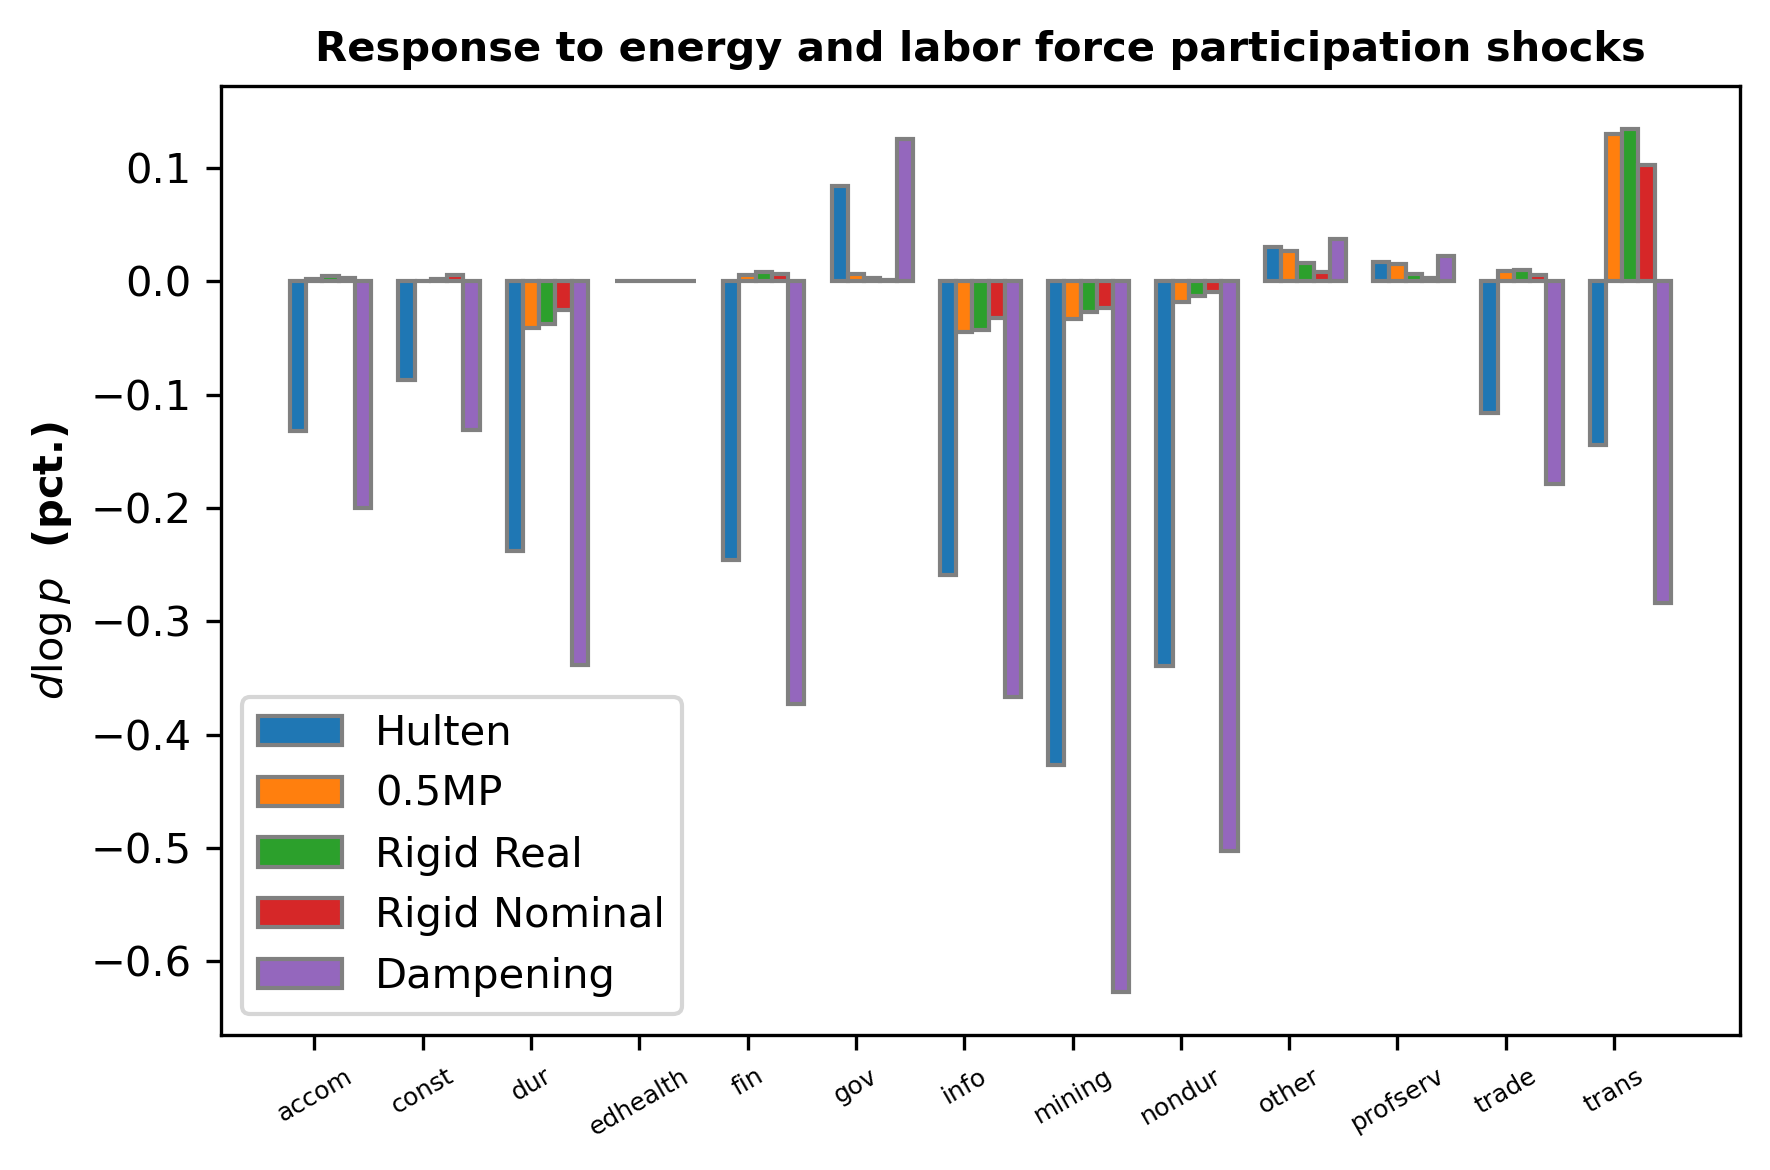

In [103]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/calib2/A{A_spec}/energy_HKshockP.png'
labels = PriceAssumption
bar_plot(100*p_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)